In [1]:
using Revise
using DrWatson

In [2]:
@quickactivate :ReactiveMPPaperExperiments

In [3]:
using Turing, Distributions, Random
using BenchmarkTools, CairoMakie, ProgressMeter, DataFrames, Query

In [4]:
# using ReverseDiff, Memoization
Turing.setadbackend(:forwarddiff)

:forwarddiff

In [5]:
@model HGF(y, zt_min_mean, zt_min_std, xt_min_mean, xt_min_std, k, w, z_std, y_std) = begin
    # Priors
    zt_min ~ Normal(zt_min_mean, zt_min_std)
    xt_min ~ Normal(xt_min_mean, xt_min_std)

    zt ~ Normal(zt_min, z_std)
    xt ~ Normal(xt_min, sqrt(exp(k * zt + w)))

    y ~ Normal(xt, y_std)
end

HGF (generic function with 2 methods)

In [6]:
params = let 
    
    seed = 123
    
    n    = 250
    τ_z  = 20.0
    τ_y  = 5.0
    
    κ = 1.0
    ω = 0.0

    @strdict seed n τ_z τ_y κ ω
end;

In [7]:
z, x, y = generate_data(HGFModel(), params);

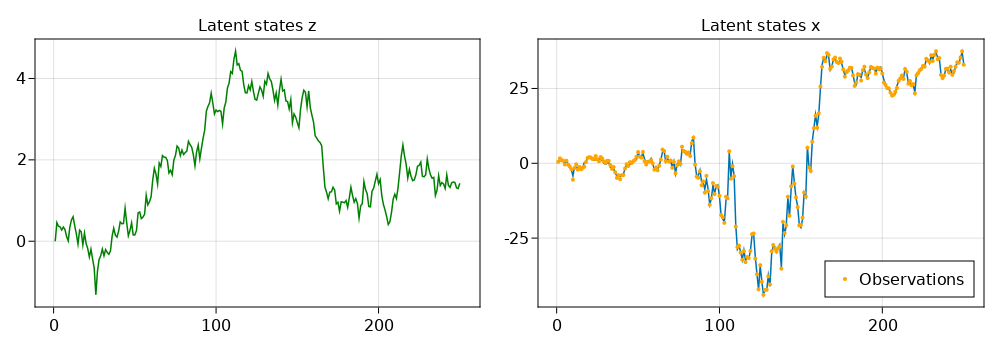

In [8]:
let 
    f = Figure(resolution = (1000, 350))
    
    range = 1:length(z)
    
    ax1 = Axis(f[1, 1], title = "Latent states z")
    ax2 = Axis(f[1, 2], title = "Latent states x")
    
    lines!(ax1, range, z, color = :green)
    
    lines!(ax2, range, x)
    scatter!(ax2, range, y, label = "Observations", markersize = 4, color = :orange)
    
    axislegend(ax2, position = :rb)
    
    f
end

# HMC inference

In [9]:
function extract_params_for_next_step(chain)
    sumstats = Turing.summarize(chain, Turing.mean, Turing.std)
    
    xt_index = findnext(e -> e === :xt, sumstats.nt.parameters, 1)
    zt_index = findnext(e -> e === :zt, sumstats.nt.parameters, 1)
    
    return (
        xt_min_mean = sumstats.nt.mean[xt_index],
        xt_min_std  = sumstats.nt.std[xt_index],
        zt_min_mean = sumstats.nt.mean[zt_index],
        zt_min_std  = sumstats.nt.std[zt_index],
    )
end


extract_params_for_next_step (generic function with 1 method)

In [10]:
function inference(y, params; nsamples = 100, method = HMC(0.1, 10))
    @unpack seed, κ, ω, τ_z, τ_y = params
    
    z_std = inv(sqrt(τ_z))
    y_std = inv(sqrt(τ_y))
    
    rng = MersenneTwister(seed)
    
    zt_min_mean = 0.0
    zt_min_std  = sqrt(5.0)
    xt_min_mean = 0.0
    xt_min_std  = sqrt(5.0)
    
    results = []
    
    @showprogress for i in 1:length(y)
        
        chain = sample(rng, HGF(y[i], zt_min_mean, zt_min_std, xt_min_mean, xt_min_std, κ, ω, z_std, y_std), method, nsamples);
        stats = extract_params_for_next_step(chain)
        
        zt_min_mean = stats[:zt_min_mean]
        xt_min_mean = stats[:xt_min_mean]
        zt_min_std = stats[:zt_min_std]
        xt_min_std = stats[:xt_min_std]
        
        push!(results, stats)
    end
    
    return results
end

inference (generic function with 1 method)

In [11]:
Turing.setprogress!(false)

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /Users/bvdmitri/.julia/packages/Turing/nfMhU/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /Users/bvdmitri/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


false

In [12]:
results = inference(y, params; nsamples = 2000, method = HMC(0.01, 20));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


In [13]:
function extract_stats(results, sym::Symbol)
    return map(i -> i[sym], results)
end

extract_stats (generic function with 1 method)

In [14]:
function _average_mse(states, estimated::AbstractVector, symbol::Symbol)
    average = zero(first(states))

    e_means = map(e -> e[Symbol(symbol, :t_min_mean)], estimated)
    e_stds  = map(e -> e[Symbol(symbol, :t_min_std)], estimated)
    
    dists = map(e -> Normal(e...), zip(e_means, e_stds))
    
    return mapreduce(+, zip(states, dists)) do (s, e)
        return var(e) + abs2(s - mean(e))
    end
end

_average_mse (generic function with 1 method)

_average_mse(z, results, :z) = 366.28475387538106
_average_mse(x, results, :x) = 380.7294162428776


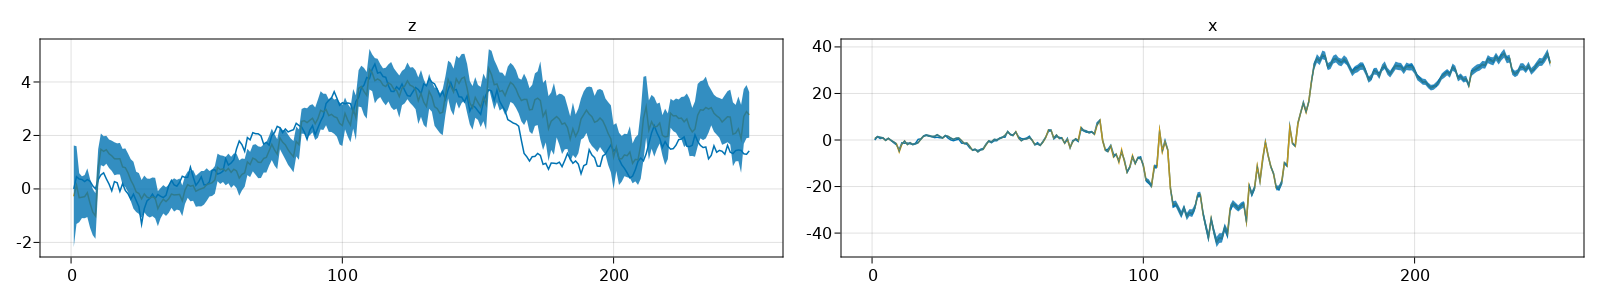

In [15]:
let
    f = Figure(resolution = (1600, 300))
    
    ax1 = Axis(f[1, 1], title = "z")
    ax2 = Axis(f[1, 2], title = "x")
    
    n = length(z)
    
    z_mean = extract_stats(results, :zt_min_mean)
    z_std  = extract_stats(results, :zt_min_std)
    
    lines!(ax1, 1:n, z)
    lines!(ax1, 1:n, z_mean)
    band!(ax1, 1:n, z_mean .- z_std, z_mean .+ z_std)
    
    x_mean = extract_stats(results, :xt_min_mean)
    x_std  = extract_stats(results, :xt_min_std)
    
    lines!(ax2, 1:n, x)
    lines!(ax2, 1:n, x_mean)
    band!(ax2, 1:n, x_mean .- x_std, x_mean .+ x_std)
    
    @show _average_mse(z, results, :z)
    @show _average_mse(x, results, :x)
    
    f
end

# ADVI inference

In [16]:
function extract_params_for_next_step_advi(model, viresult)
    
    means   = viresult.dist.m
    stds    = viresult.dist.σ
    _, sym2range = Turing.bijector(model, Val(true));
    
    return (
        xt_min_mean = means[sym2range[:xt][1]][1],
        xt_min_std  = stds[sym2range[:xt][1]][1],
        zt_min_mean = means[sym2range[:zt][1]][1],
        zt_min_std  = stds[sym2range[:zt][1]][1],
    )
end


extract_params_for_next_step_advi (generic function with 1 method)

In [17]:
function inference_advi(y, params; method = ADVI(3, 2500))
    @unpack seed, κ, ω, τ_z, τ_y = params
    
    z_std = inv(sqrt(τ_z))
    y_std = inv(sqrt(τ_y))
    
    # ADVI does not support local `rng`,
    # se we set rng globally
    Random.seed!(seed)
    
    zt_min_mean = 0.0
    zt_min_std  = sqrt(5.0)
    xt_min_mean = 0.0
    xt_min_std  = sqrt(5.0)
    
    results = []
    
    # `TruncatedADAGrad` outputs a lot of warnings
    optimizer = Turing.Variational.DecayedADAGrad()
    
    @showprogress for i in 1:length(y)
        
        model = HGF(y[i], zt_min_mean, zt_min_std, xt_min_mean, xt_min_std, κ, ω, z_std, y_std)
        # We use mean-field assumption here
        # While mean-field is not great for state-space models, making it structured 
        # inevitably increases computational complexity of the method
        # and will use much more time to run inference
        q0 = Turing.Variational.meanfield(model)
        
        viresult = Turing.vi(model, method, q0; optimizer = optimizer)
        stats    = extract_params_for_next_step_advi(model, viresult)
        
        zt_min_mean = stats[:zt_min_mean]
        xt_min_mean = stats[:xt_min_mean]
        zt_min_std = stats[:zt_min_std]
        xt_min_std = stats[:xt_min_std]
        
        push!(results, stats)
    end
    
    return results
end

inference_advi (generic function with 1 method)

In [18]:
results_advi = inference_advi(y, params; method = ADVI(1, 20_000));

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


_average_mse(z, results_advi, :z) = 261.28755544027024
_average_mse(x, results_advi, :x) = 105.52032547804664


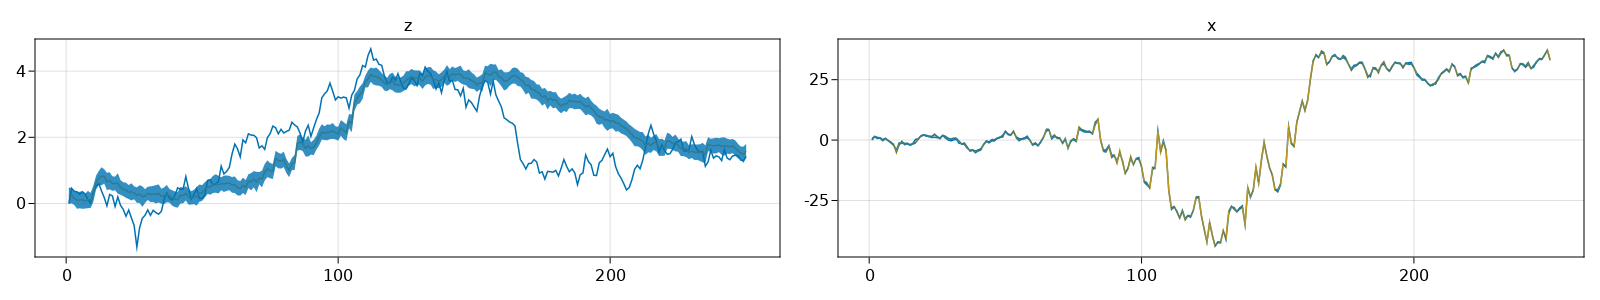

In [19]:
let
    f = Figure(resolution = (1600, 300))
    
    ax1 = Axis(f[1, 1], title = "z")
    ax2 = Axis(f[1, 2], title = "x")
    
    n = length(z)
    
    z_mean = extract_stats(results_advi, :zt_min_mean)
    z_std  = extract_stats(results_advi, :zt_min_std)
    
    lines!(ax1, 1:n, z)
    lines!(ax1, 1:n, z_mean)
    band!(ax1, 1:n, z_mean .- z_std, z_mean .+ z_std)
    
    x_mean = extract_stats(results_advi, :xt_min_mean)
    x_std  = extract_stats(results_advi, :xt_min_std)
    
    lines!(ax2, 1:n, x)
    lines!(ax2, 1:n, x_mean)
    band!(ax2, 1:n, x_mean .- x_std, x_mean .+ x_std)
    
    @show _average_mse(z, results_advi, :z)
    @show _average_mse(x, results_advi, :x)
    
    f
end

# HMC benchmark

In [20]:
function run_benchmark(params)
    @unpack seed, n, nsamples, κ, ω, τ_z, τ_y, ϵ, leapfrog = params

    z, s, y = generate_data(HGFModel(), params);
    
    method = HMC(ϵ, leapfrog);

    results    = inference(y, params; nsamples = nsamples, method = method);
    benchmark  = @benchmark inference($y, $params; nsamples = $nsamples, method = $method);
    
    z_amse = _average_mse(z, results, :z)
    s_amse = _average_mse(s, results, :x)
    
    emse_range = (seed):(seed + 10)
    
    emse = (1.0 / length(emse_range)) .* mapreduce(.+, emse_range) do _seed
        local cparams = deepcopy(params); cparams["seed"] = _seed;
        local z, s, y = generate_data(HGFModel(), cparams);
        local results = inference(y, cparams; nsamples = nsamples, method = method);
        local z_amse = _average_mse(z, results, :z)
        local s_amse = _average_mse(s, results, :x)
        return (z_amse, s_amse)
    end

    output = @strdict n seed nsamples τ_z τ_y κ ω results benchmark z_amse s_amse emse ϵ leapfrog

    return output
end

run_benchmark (generic function with 1 method)

In [21]:
benchmark_params = dict_list(Dict(
    "n"         => [ 50, 100, 250 ],
    "nsamples"  => [ 250, 500, 1000, 2000, 5000 ],
    "seed"  => 12,
    "τ_z"   => 20.0,
    "τ_y"   => 5.0,
    "κ"     => 1.0,
    "ω"     => 0.0,
    "ϵ"     => 0.1, # [ 0.01, 0.05, 0.1 ],
    "leapfrog" => 10, # [ 10, 20, 30 ]
));

In [22]:
import Logging

Logging.disable_logging(Logging.Warn) # or e.g. Logging.Info

LogLevel(1001)

In [23]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
turing_benchmarks = map(benchmark_params) do params
    path = datadir("benchmark", "hgf", "turing")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark(p)
    end
    return result
end;

In [24]:
target_seed = 12
target_nsamples = 1000
target_ϵ = 0.1
target_leapfrog = 10

10

In [25]:
let

    white_list   = [ "n", "seed", "nsamples", "z_amse", "s_amse", "ϵ", "leapfrog" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :gctime => (data) -> string(round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"),
        :z_emse_n => (data) -> string(round(data["emse"][1] / data["n"], digits = 2)),
        :s_emse_n => (data) -> string(round(data["emse"][2] / data["n"], digits = 2)),
    ]

    df = collect_benchmarks(turing_benchmarks, white_list = white_list, special_list = special_list)

    query = @from row in df begin
        @where row.seed == target_seed && row.nsamples == target_nsamples#  && row.ϵ == target_ϵ && row.leapfrog == target_leapfrog
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime, row.z_amse, row.s_amse, row.z_emse_n, row.s_emse_n }
    end

    DataFrame(query) 
end

,n,min,gctime,z_amse,s_amse,z_emse_n,s_emse_n
,Int64,String,String,Float64,Float64,String,String
1,50,2391.48ms,11.35%,76.4348,20.8954,1.3,0.41
2,100,4810.71ms,12.36%,114.838,43.8764,1.14,0.49
3,250,12058.89ms,12.64%,285.812,147.202,1.22,2.56


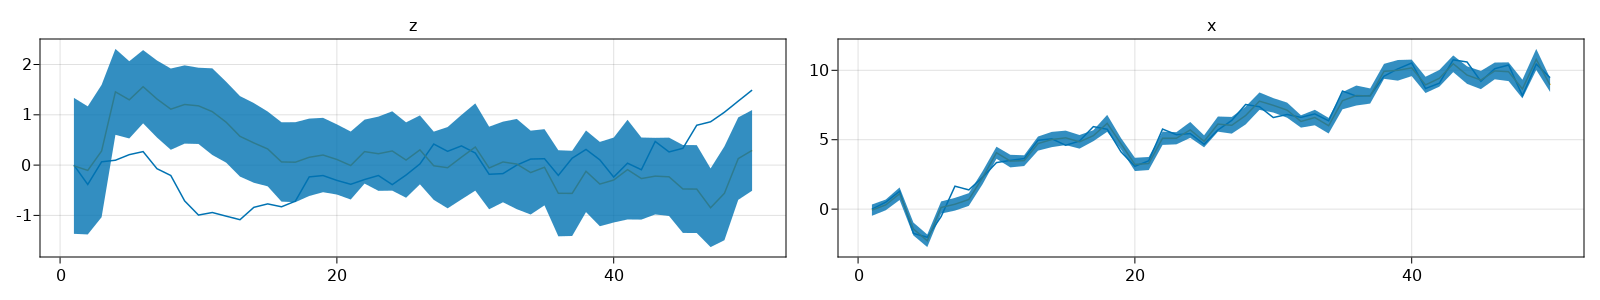

In [26]:
let
    verification_index = 1
    
    verification_benchmark = turing_benchmarks[verification_index]
    
    f = Figure(resolution = (1600, 300))

    local z, x, y = generate_data(HGFModel(), verification_benchmark);
    
    ax1 = Axis(f[1, 1], title = "z")
    ax2 = Axis(f[1, 2], title = "x")
    
    n = length(z)
    
    z_mean = extract_stats(verification_benchmark["results"], :zt_min_mean)
    z_std  = extract_stats(verification_benchmark["results"], :zt_min_std)
    
    lines!(ax1, 1:n, z)
    lines!(ax1, 1:n, z_mean)
    band!(ax1, 1:n, z_mean .- z_std, z_mean .+ z_std)
    
    x_mean = extract_stats(verification_benchmark["results"], :xt_min_mean)
    x_std  = extract_stats(verification_benchmark["results"], :xt_min_std)
    
    lines!(ax2, 1:n, x)
    lines!(ax2, 1:n, x_mean)
    band!(ax2, 1:n, x_mean .- x_std, x_mean .+ x_std)
    
    f
end

# Benchmark ADVI

In [27]:
function run_benchmark_advi(params)
    @unpack seed, n, κ, ω, τ_z, τ_y, samples_per_step, max_iters = params

    z, s, y = generate_data(HGFModel(), params);
    
    method = ADVI(samples_per_step, max_iters);

    results    = inference_advi(y, params; method = method);
    benchmark  = @benchmark inference_advi($y, $params; method = $method);
    
    z_amse = _average_mse(z, results, :z)
    s_amse = _average_mse(s, results, :x)
    
    emse_range = (seed):(seed + 10)
    
    emse = (1.0 / length(emse_range)) .* mapreduce(.+, emse_range) do _seed
        local cparams = deepcopy(params); cparams["seed"] = _seed;
        local z, s, y = generate_data(HGFModel(), cparams);
        local results = inference_advi(y, cparams; method = method);
        local z_amse = _average_mse(z, results, :z)
        local s_amse = _average_mse(s, results, :x)
        return (z_amse, s_amse)
    end

    output = @strdict n seed τ_z τ_y κ ω results benchmark z_amse s_amse emse samples_per_step max_iters

    return output
end

run_benchmark_advi (generic function with 1 method)

In [28]:
benchmark_params_advi = dict_list(Dict(
    "n"         => [ 50, 100, 250 ],
    "seed"  => 12,
    "τ_z"   => 20.0,
    "τ_y"   => 5.0,
    "κ"     => 1.0,
    "ω"     => 0.0,
    "samples_per_step" => [ 1, 2, 3, 5, 7, 11 ], 
    "max_iters"        => [ 10_000, 15_000, 20_000, 30_000 ]
));

In [ ]:
# First run maybe slow, you may track the progress in the terminal
# Subsequent runs will not create new benchmarks 
# but will reload it from data folder
turing_benchmarks_advi = map(benchmark_params_advi) do params
    path = datadir("benchmark", "hgf", "turing_advi")
    result, _ = produce_or_load(path, params; tag = false) do p
        run_benchmark_advi(p)
    end
    return result
end;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:15
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:07
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44
Progress: 100%|█████████████████████████████████████████| Time: 

Progress: 100%|█████████████████████████████████████████| Time: 0:02:02
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08
Progress: 100%|█████████████████████████████████████████| Time: 0:02:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:12
Progress: 100%|█████████████████████████████████████████| Time: 0:02:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:05
Progress: 100%|█████████████████████████████████████████| Time: 0:02:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08
Progress: 100%|█████████████████████████████████████████| Time: 0:02:06
Progress: 100%|█████████████████████████████████████████| Time: 0:02:07
Progress: 100%|█████████████████████████████████████████| Time: 0:02:03
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08
Progress: 100%|█████████████████████████████████████████| Time: 

In [ ]:
target_advi_seed = 12
target_advi_samples_per_step = 11
target_advi_max_iters = 30_000

In [ ]:
let

    white_list   = [ "n", "seed", "nsamples", "z_amse", "s_amse", "samples_per_step", "max_iters" ]
    special_list = [
        :min => (data) -> string(round(minimum(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :mean => (data) -> string(round(mean(data["benchmark"]).time / 1_000_000, digits = 2), "ms"),
        :gctime => (data) -> string(round(minimum(data["benchmark"]).gctime / minimum(data["benchmark"]).time * 100, digits = 2), "%"),
        :z_emse_n => (data) -> string(round(data["emse"][1] / data["n"], digits = 2)),
        :s_emse_n => (data) -> string(round(data["emse"][2] / data["n"], digits = 2)),
    ]

    df = collect_benchmarks(turing_benchmarks_advi, white_list = white_list, special_list = special_list)

    query = @from row in df begin
        @where row.seed == target_advi_seed && row.samples_per_step == target_advi_samples_per_step && row.max_iters == target_advi_max_iters #  && row.ϵ == target_ϵ && row.leapfrog == target_leapfrog
        @orderby ascending(row.n)
        @select { row.n, row.min, row.gctime, row.z_amse, row.s_amse, row.z_emse_n, row.s_emse_n }
    end

    DataFrame(query) 
end

In [ ]:
let
    verification_index = 1
    
    verification_benchmark = turing_benchmarks_advi[verification_index]
    
    f = Figure(resolution = (1600, 300))

    local z, x, y = generate_data(HGFModel(), verification_benchmark);
    
    ax1 = Axis(f[1, 1], title = "z")
    ax2 = Axis(f[1, 2], title = "x")
    
    n = length(z)
    
    z_mean = extract_stats(verification_benchmark["results"], :zt_min_mean)
    z_std  = extract_stats(verification_benchmark["results"], :zt_min_std)
    
    lines!(ax1, 1:n, z)
    lines!(ax1, 1:n, z_mean)
    band!(ax1, 1:n, z_mean .- z_std, z_mean .+ z_std)
    
    x_mean = extract_stats(verification_benchmark["results"], :xt_min_mean)
    x_std  = extract_stats(verification_benchmark["results"], :xt_min_std)
    
    lines!(ax2, 1:n, x)
    lines!(ax2, 1:n, x_mean)
    band!(ax2, 1:n, x_mean .- x_std, x_mean .+ x_std)
    
    f
end

In [ ]:
versioninfo()